The code below sets up the environment for running the experiments on our code

In [2]:
!pip install pillow


!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c pytorch pytorch torchvision cudatoolkit=10.1
!conda install -y --prefix /usr/local -c conda-forge tweepy
!conda install -y --prefix /usr/local -c conda-forge gensim
!conda install -y --prefix /usr/local -c conda-forge pandas
!conda install -y --prefix /usr/local -c conda-forge numpy
!conda install -y --prefix /usr/local -c conda-forge tqdm
!conda install -y --prefix /usr/local -c conda-forge matplotlib
!conda install -y --prefix /usr/local -c conda-forge scikit-learn

!pip install pywikibot
!pip install nltk
!pip install astar-tcn --no-dependencies
!pip install langdetect

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
! git clone https://github.com/Snover98/BotDetectionDT.git
import nltk
nltk.download('stopwords')
nltk.download('punkt')

--2019-11-08 12:54:07--  https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.4-hc3d631a_1 ...
Python 3.6.4 :: Anaconda, Inc.
installing: ca-certificates-2017.08.26-h1d4fec5_0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-hc7b2577_8 ...
installing: libgcc-ng-7.2.0-h7cc24e2_2 ...
installing: libgfortran-ng-7.2.0-h9f7466a_2 ...
installing: libstdcxx-ng-7.2.0-h7a57d05_2 ...
installing: bzip2-1.0.6-h9a117a8_4 ...
installing: expat-2.2.5-he0dffb1_0 ...
installing: gmp-6.1.2-h6c8ec71_1 ...
installing: graphite2-1.3.10-hf63cedd_1 ...
installing: icu-58.2-h9c2bf20_1 ...
installing: jbig

True

Change working directory into the project

In [0]:
import os
os.chdir('/content/BotDetectionDT')

Import all needed modules

In [0]:
import torch
from torch import nn
from torch.optim.adam import Adam
from torch.optim.sgd import SGD
from gensim.models import Word2Vec
import argparse
from model.classification_model import BotClassifier
from training.training_utils import TorchTrainer, plot_fit, display_fit_result
from data.dataset import get_dataloaders, UsersDataset
import matplotlib.pyplot as plt

Constant global variables for our runs

In [5]:
num_epochs = 90
loss_fn = nn.CrossEntropyLoss()

ds = UsersDataset(it_flag=True)
train_dl, test_dl = get_dataloaders(ds, train_ratio=0.8, batch_size=8, load_rand_state=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

w2v_model = Word2Vec.load("checkpoints/word2vec.model")
fig=None

Saving random state into rand_state.pickle


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
run_name = "Final_Training"

Training function

In [0]:
def train_model(run_name, fig=None, embedding_dim=100, rec_hidden_dim=1024, tweet_features_dim=1024, hidden_dim=1024, use_gdelt=False, use_TCN=False, use_checkpoint=True, effective_history=60,
                num_rec_layers=1, rec_dropout=0.0, use_SGD=True, learning_rate=0.01, weight_decay=0.0, early_stopping=None):
  temporal_ext_name = "TCN" if use_TCN else "LSTM"
  subrun_name = f"{run_name}_{temporal_ext_name}"
  if use_gdelt:
    subrun_name += "_GDELT"
  
  clf = BotClassifier(w2v_model, embedding_dim, rec_hidden_dim, tweet_features_dim, hidden_dim, use_gdelt=use_gdelt, use_TCN=use_TCN,
                      effective_history=effective_history, num_rec_layers=num_rec_layers, rec_dropout=rec_dropout).to(device)
  if use_SGD:
    optim = SGD(params=clf.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim = Adam(params=clf.parameters(), lr=learning_rate, weight_decay=weight_decay)
  
  trainer = TorchTrainer(clf, loss_fn, optim, device=device)
  
  checkpoint_file = None
  if use_checkpoint:
    checkpoint_file = f"{subrun_name}.model"

  print("================================================================================")
  print("===============================|STARTED TRAINING|===============================")
  print("================================================================================")
  print(f'Training with extractor {temporal_ext_name} and use_gdelt={use_gdelt}:')
  fit_res = trainer.fit(train_dl, test_dl, num_epochs, checkpoints=checkpoint_file)
  print("================================================================================")
  print('===================================|FINISHED|===================================')
  print("================================================================================")
  print('')
  display_fit_result(fit_res)

  fig, _ = plot_fit(fit_res, fig=fig, legend=subrun_name.replace('_', ' '))

  return fig, clf

===============================|STARTED TRAINING|===============================
Training with extractor LSTM and use_gdelt=False:
--- EPOCH 1/50 ---
test_batch (Avg. Loss 0.588, Accuracy 73.7): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]
--- EPOCH 2/50 ---
test_batch (Avg. Loss 0.584, Accuracy 73.7): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
--- EPOCH 3/50 ---
test_batch (Avg. Loss 0.594, Accuracy 73.7): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
--- EPOCH 4/50 ---
test_batch (Avg. Loss 0.618, Accuracy 68.4): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
--- EPOCH 5/50 ---
test_batch (Avg. Loss 0.628, Accuracy 68.4): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
--- EPOCH 6/50 ---
test_batch (Avg. Loss 0.639, Accuracy 71.1): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
--- EPOCH 7/50 ---
test_batch (Avg. Loss 0.599, Accuracy 73.7): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
--- EPOCH 8/50 ---
test_batch (Avg. Loss 0.623, Accuracy 65.8): 100%|██████████| 5/5 [00:03<00:00, 

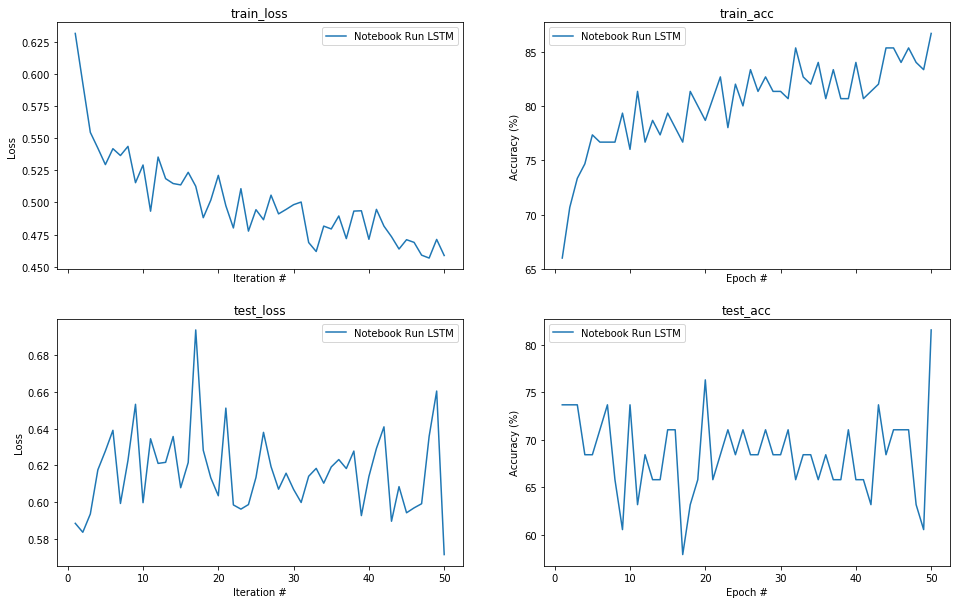

In [19]:
fig, clf = train_model(run_name, weight_decay=0.001)

In [20]:
fig.suptitle("Bot Network Training")

Text(0.5, 0.98, 'Notebook Run')

===============================|STARTED TRAINING|===============================
Training with extractor TCN and use_gdelt=False:
--- EPOCH 1/50 ---
test_batch (Avg. Loss 0.632, Accuracy 71.1): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
--- EPOCH 2/50 ---
test_batch (Avg. Loss 0.624, Accuracy 68.4): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
--- EPOCH 3/50 ---
test_batch (Avg. Loss 0.601, Accuracy 71.1): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
--- EPOCH 4/50 ---
test_batch (Avg. Loss 0.576, Accuracy 73.7): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
--- EPOCH 5/50 ---
test_batch (Avg. Loss 0.621, Accuracy 68.4): 100%|██████████| 5/5 [00:03<00:00,  1.72it/s]
--- EPOCH 6/50 ---
test_batch (Avg. Loss 0.568, Accuracy 71.1): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
--- EPOCH 7/50 ---
test_batch (Avg. Loss 0.577, Accuracy 73.7): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
--- EPOCH 8/50 ---
test_batch (Avg. Loss 0.585, Accuracy 73.7): 100%|██████████| 5/5 [00:03<00:00,  

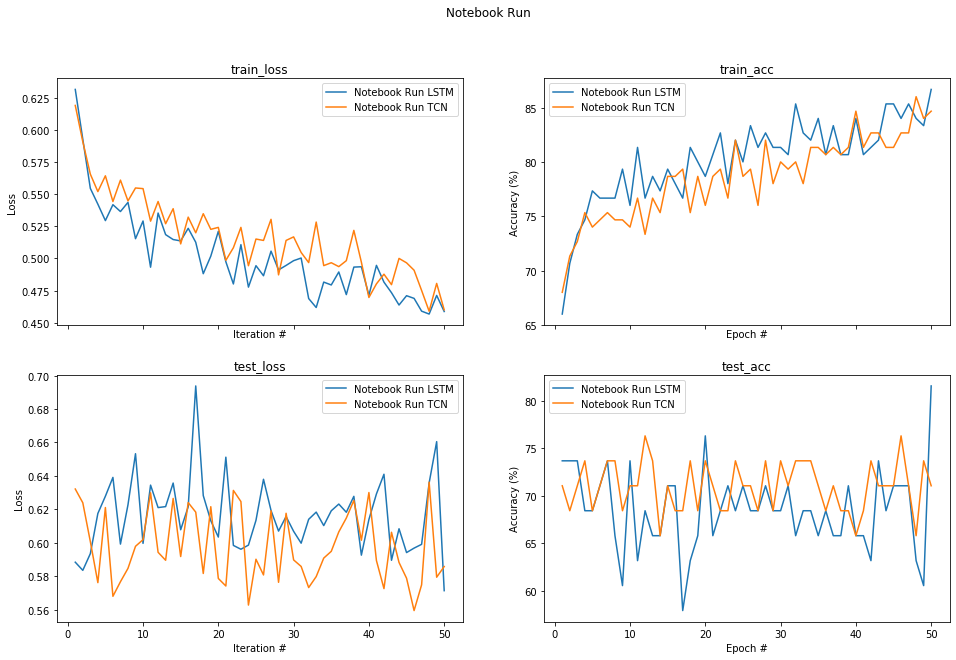

In [21]:
fig, clf2 = train_model(run_name, fig, use_TCN=True, rec_hidden_dim=256, weight_decay=0.001)

In [0]:
fig, clf3 = train_model(run_name, fig, use_gdelt=True, rec_dropout=0.2, weight_decay=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


===============================|STARTED TRAINING|===============================
Training with extractor LSTM and use_gdelt=True:
--- EPOCH 1/50 ---

train_batch (Avg. Loss 0.615, Accuracy 68.7): 100%|██████████| 19/19 [03:07<00:00, 15.00s/it]

test_batch (Avg. Loss 0.578, Accuracy 73.7): 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]
--- EPOCH 2/50 ---

train_batch (Avg. Loss 0.560, Accuracy 76.0): 100%|██████████| 19/19 [03:06<00:00, 14.14s/it]

test_batch (Avg. Loss 0.575, Accuracy 73.7): 100%|██████████| 5/5 [00:28<00:00,  5.58s/it]
--- EPOCH 3/50 ---

train_batch (Avg. Loss 0.561, Accuracy 70.7): 100%|██████████| 19/19 [03:12<00:00,  7.42s/it]

test_batch (Avg. Loss 0.585, Accuracy 73.7): 100%|██████████| 5/5 [00:27<00:00,  5.22s/it]
--- EPOCH 4/50 ---

train_batch (Avg. Loss 0.528, Accuracy 77.3): 100%|██████████| 19/19 [03:05<00:00,  2.80s/it]

test_batch (Avg. Loss 0.570, Accuracy 71.1): 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]
--- EPOCH 5/50 ---

train_batch (Avg. Loss 0.5

In [22]:
fig, clf4 = train_model(run_name, fig, use_TCN=True, rec_hidden_dim=256, rec_dropout=0.2, use_gdelt=True, weight_decay=0.001)

===============================|STARTED TRAINING|===============================
Training with extractor TCN and use_gdelt=True:
--- EPOCH 1/50 ---
test_batch (Avg. Loss 0.671, Accuracy 68.4): 100%|██████████| 5/5 [00:40<00:00,  9.90s/it]
--- EPOCH 2/50 ---
test_batch (Avg. Loss 0.595, Accuracy 73.7): 100%|██████████| 5/5 [00:37<00:00,  9.24s/it]
--- EPOCH 3/50 ---
test_batch (Avg. Loss 0.597, Accuracy 71.1): 100%|██████████| 5/5 [00:36<00:00,  9.00s/it]
--- EPOCH 4/50 ---
test_batch (Avg. Loss 0.593, Accuracy 71.1): 100%|██████████| 5/5 [00:38<00:00,  9.29s/it]
--- EPOCH 5/50 ---
test_batch (Avg. Loss 0.581, Accuracy 73.7): 100%|██████████| 5/5 [00:36<00:00,  8.91s/it]
--- EPOCH 6/50 ---
test_batch (Avg. Loss 0.583, Accuracy 73.7): 100%|██████████| 5/5 [00:34<00:00,  8.38s/it]
--- EPOCH 7/50 ---
test_batch (Avg. Loss 0.582, Accuracy 73.7): 100%|██████████| 5/5 [00:36<00:00,  8.79s/it]
--- EPOCH 8/50 ---
test_batch (Avg. Loss 0.582, Accuracy 73.7): 100%|██████████| 5/5 [00:41<00:00, 10

In [1]:
fig

NameError: ignored

In [0]:
plt.savefig(f"graphs/{run_name}.png")